# DSI37 Capstone Project: Skin Disease Classification Using Computer Vision

<a id='part_ii'></a>
[Part I](Part1-Intro_Eda.ipynb#part_i) <br>
[Part III](Part3-VggModel.ipynb#part_iii) <br>
[Part IV](Part4-ResnetModel.ipynb#part_iv) <br>
[Part V](Part5-Ensemble_Insights_Recommendations.ipynb#part_v)

<a id='part_ii'></a>
# Part 2: Transfer Learning with EfficientNetV2L

## Contents
[1. Importing Libraries](#imports) <br>
[2. Importing and Preprocessing Data](#data) <br>
[3. Hyperparameter Tuning](#hypertuning) <br>
[4. Model](#model) <br>
[5. Fine Tuning](#finetuning) <br>

<a id='imports'></a>
## 1. Importing Libraries

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Pip install keras tuner
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.9 MB/s eta 0:00:00


In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.vgg16 import VGG16
import keras_tuner
from keras_tuner.tuners import BayesianOptimization
from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten
from keras import backend as K

<a id='data'></a>
## 2. Importing and Preprocessing Data

In [4]:
# Setting directories
cwd = '/content/drive/MyDrive/Colab Notebooks/Capstone 3'
data_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone 3/data'
model_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone 3/models'

In [5]:
# Setting batch size and image size
batch_size = 32
img_height = 224
img_width = 224

# Create train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

Found 3265 files belonging to 5 classes.
Using 2612 files for training.
Found 3265 files belonging to 5 classes.
Using 653 files for validation.


In [6]:
# Get the class labels and number of classes from the dataset
class_labels = train_ds.class_names
num_classes = len(class_labels)
print('Class labels:', class_labels)
print("Number of classes:", num_classes)

# Create the inverse mapping of class indices to class labels
inv_map_classes = {i: label for i, label in enumerate(class_labels)}
map_classes = {label: i for i, label in enumerate(class_labels)}
print('Inverse mapping of classes:', inv_map_classes)
print('Mapping of classes:', map_classes)

Class labels: ['acne', 'eczema', 'fungal', 'psoriasis', 'warts']
Number of classes: 5
Inverse mapping of classes: {0: 'acne', 1: 'eczema', 2: 'fungal', 3: 'psoriasis', 4: 'warts'}
Mapping of classes: {'acne': 0, 'eczema': 1, 'fungal': 2, 'psoriasis': 3, 'warts': 4}


In [7]:
# Creating test dataset
val_batches = val_ds.cardinality()
test_ds = val_ds.take(val_batches // 5) # Moving 20% into test dataset
val_ds = val_ds.skip(val_batches // 5)
print('Number of validation batches: %d' % val_ds.cardinality())
print('Number of test batches: %d' % test_ds.cardinality())

Number of validation batches: 17
Number of test batches: 4


In [8]:

# Prepare all train/validation/test datasets
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

<a id='hypertuning'></a>
## 3. Hyperparameter Tuning

In [9]:
# Create function to add data augmentation layer
def create_augmentation(level):
  """This function accepts a string argument to determine the level of data augmentation to apply"""
  if level == 'medium':
    data_augmentation = tf.keras.Sequential([
        layers.RandomRotation(factor=0.15),
        layers.RandomContrast(factor=0.1)
    ])
    return data_augmentation
  elif level == 'hard':
    data_augmentation = tf.keras.Sequential([
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.1)
      ])
    return data_augmentation
  else:
    data_augmentation = tf.keras.Sequential([
        layers.RandomRotation(factor=0.15)
    ])
    return data_augmentation

In [ ]:
# Modifying HyperModel subclass
class EffHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
      # Load base model
      base_model = EfficientNetV2L(weights='imagenet',
                                  include_top=False,
                                  input_shape=(img_height, img_width, 3))

      # Freeze the base model weights
      base_model.trainable = False

      # Specify model architecture (Feature extraction)
      inputs = keras.Input(shape=(img_height, img_width, 3))
      x = keras.applications.efficientnet.preprocess_input(inputs)
      # Tune Data Augmentation
      augment_level = hp.Choice('augment', ['soft', 'medium', 'hard'])
      x = create_augmentation(augment_level)(x)
      x = base_model(x, training=False)
      # Flatten vs GlobalAvgPooling
      if hp.Boolean('GlobalPool'):
        x = GlobalAveragePooling2D()(x)
      else:
        x = Flatten()(x)
      # Tune number of units in the Dense layer
      x = Dense(units=hp.Int('units_1', 512, 1028, step=64), activation='relu')(x)
      # Tune batch normalization
      if hp.Boolean('batch_norm'):
        x = layers.BatchNormalization()(x)
      # Tune dropout rate
      x = Dropout(hp.Float('dropout', min_value= 0.1, max_value=0.5, step= 0.1))(x)
      outputs = Dense(num_classes, activation='softmax')(x)
      model = Model(inputs, outputs)

      # Tune the optimizer
      optimizer = hp.Choice('optim', ['adam', 'sgd'])

      if optimizer=='sgd':
        optimizer = keras.optimizers.SGD(momentum=0.9, nesterov=True)
      else:
        optimizer = keras.optimizers.Adam()

      model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

      # Tune learning rate
      learning_rate = hp.Float('lr', min_value=1e-3, max_value=1e-2, sampling='log')
      K.set_value(model.optimizer.learning_rate, learning_rate)

      return model

    def fit(self, hp, model, x, validation_data, *args, **kwargs):
        return model.fit(train_ds,
                         validation_data=val_ds,
                         *args,
                         **kwargs)

In [ ]:
# Specifying tuner settings
tuner = BayesianOptimization(hypermodel=EffHyperModel(),
                            objective='val_accuracy',
                            max_trials=15,
                            overwrite=True,
                            directory="/content/drive/MyDrive/Colab Notebooks/Capstone 3/effhypermodel",
                            project_name="/content/drive/MyDrive/Colab Notebooks/Capstone 3/effhypermodel/bayesian")

In [ ]:
# Print summary of search space
tuner.search_space_summary()

Search space summary
Default search space size: 7
augment (Choice)
{'default': 'soft', 'conditions': [], 'values': ['soft', 'medium', 'hard'], 'ordered': False}
GlobalPool (Boolean)
{'default': False, 'conditions': []}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 1028, 'step': 64, 'sampling': 'linear'}
batch_norm (Boolean)
{'default': False, 'conditions': []}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optim (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
lr (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
# Set earlystopping
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              patience=6,
                              verbose=1)

# Running keras tuner
tuner.search(x=train_ds,
             epochs=10,
             validation_data=val_ds,
             verbose=1,
             callbacks=[earlystopping])

Trial 15 Complete [00h 09m 26s]
val_accuracy: 0.6761904954910278

Best val_accuracy So Far: 0.7276190519332886
Total elapsed time: 02h 07m 00s


In [ ]:
# Show result summary of top 3 trials
tuner.results_summary(3)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/Capstone 3/effhypermodel/bayesian
Showing 3 best trials
Objective(name="val_accuracy", direction="max")

Trial 12 summary
Hyperparameters:
augment: medium
GlobalPool: False
units_1: 640
batch_norm: True
dropout: 0.5
optim: sgd
lr: 0.0036662257907613123
Score: 0.7276190519332886

Trial 02 summary
Hyperparameters:
augment: medium
GlobalPool: True
units_1: 832
batch_norm: True
dropout: 0.30000000000000004
optim: sgd
lr: 0.001924729449542274
Score: 0.7219047546386719

Trial 07 summary
Hyperparameters:
augment: medium
GlobalPool: True
units_1: 832
batch_norm: False
dropout: 0.30000000000000004
optim: adam
lr: 0.0030242699456605993
Score: 0.7219047546386719


In [ ]:
# Define function to update results of hypertuning
def update_results(num_trials, network):
  trial_df = pd.DataFrame(columns=['network', 'augment', 'GlobalPool', 'units_1', 'batch_norm', 'dropout', 'optim', 'lr', 'score'])
  trials = [str(number).zfill(2) for number in range(num_trials)]
  for i, trial in enumerate(trials):
    df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Capstone 3/effhypermodel/bayesian/trial_' + trial + '/trial.json')
    metrics_dict = df.loc['values', 'hyperparameters']
    metrics_dict['score'] = df.loc['values', 'score']
    metrics_df = pd.DataFrame(metrics_dict, index=[i])
    metrics_df['network'] = network
    trial_df = pd.concat([trial_df, metrics_df])
  return trial_df

In [ ]:
# Update results
trial_df = update_results(15, 'EfficientNet')

# Save hyperparameter tuning results as csv
trial_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Capstone 3/dataframes/effnet_hypertuning.csv', index=False)

<ipython-input-14-c6f4625ef43b>:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  trial_df = pd.concat([trial_df, metrics_df])
<ipython-input-14-c6f4625ef43b>:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  trial_df = pd.concat([trial_df, metrics_df])
<ipython-input-14-c6f4625ef43b>:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  trial_df = pd.concat([trial_df, metrics_df])
<ipython-input-14-c6f4625ef43b>:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  trial_df = pd.concat(

In [ ]:
# Display summary of hyperparameter tuning
display(trial_df.sort_values(by='score', ascending=False))

,network,augment,GlobalPool,units_1,batch_norm,dropout,optim,lr,score
12,EfficientNet,medium,False,640,True,0.5,sgd,0.003666,0.727619
2,EfficientNet,medium,True,832,True,0.3,sgd,0.001925,0.721905
7,EfficientNet,medium,True,832,False,0.3,adam,0.003024,0.721905
11,EfficientNet,soft,True,512,True,0.3,adam,0.001221,0.720000
0,EfficientNet,soft,True,896,False,0.1,adam,0.005955,0.718095
4,EfficientNet,medium,True,576,False,0.4,sgd,0.009126,0.718095
13,EfficientNet,soft,False,768,True,0.5,adam,0.001675,0.700952
10,EfficientNet,hard,True,768,False,0.1,adam,0.001134,0.697143
1,EfficientNet,soft,False,640,True,0.1,adam,0.001769,0.695238
8,EfficientNet,medium,True,704,True,0.5,adam,0.005338,0.689524


<a id='model'></a>
## 4. Model

In [ ]:
# Specify model architecture
inputs = keras.Input(shape=(img_height, img_width, 3))
x = keras.applications.efficientnet.preprocess_input(inputs)
x = create_augmentation('hard')(x)
base_model = EfficientNetV2L(weights='imagenet',
                            include_top=False,
                            input_shape=(img_height, img_width, 3),
                            input_tensor=x)
base_model.trainable = False
x = Flatten()(base_model.output)
# Tune number of units in the Dense layer
x = Dense(576, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)
eff_model = Model(inputs, outputs)

optimizer = keras.optimizers.SGD(learning_rate=0.002246848885190795, momentum=0.9, nesterov=True)
eff_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
# Define function to obtain callbacks
def get_callbacks(model_file, patience, lr_factor):
  ''' Callbacks used for saving the best weights, early stopping and learning rate scheduling.
  - model_file (str) is the file name for the saved model in the form of {file_name.h5}
  - patience (int) is the patience used for early stopping and learning rate scheduling
  - lr_factor (float) is the factor used to reduce the learning rate when val_loss has not decreased for patience//2 epochs
  '''

  modelcheckpoint = ModelCheckpoint(os.path.join(model_dir, model_file),
                                    monitor='val_accuracy',
                                    mode="max",
                                    save_best_only=True,
                                    save_weights_only=False)

  earlystop = EarlyStopping(monitor="val_loss",
                            mode="min",
                            patience = patience,
                            verbose=1)

  reducelronplateau = ReduceLROnPlateau(monitor="val_loss",
                                        mode="min",
                                        factor=lr_factor,
                                        min_lr=1e-6,
                                        patience=patience//2,
                                        verbose=1)

  return [modelcheckpoint, earlystop, reducelronplateau]

In [ ]:
# Specify callbacks
callback_list = get_callbacks('eff_model2.h5',
                              patience=10,
                              lr_factor=0.1)

# Fit the model
eff_history = eff_model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=30,
                            callbacks=callback_list)

Epoch 1/30
82/82 [==============================] - 91s 672ms/step - loss: 1.2210 - accuracy: 0.4832 - val_loss: 0.9733 - val_accuracy: 0.5981 - lr: 0.0022
Epoch 2/30
82/82 [==============================] - 42s 503ms/step - loss: 0.9446 - accuracy: 0.5907 - val_loss: 1.0001 - val_accuracy: 0.5638 - lr: 0.0022
Epoch 3/30
82/82 [==============================] - 51s 619ms/step - loss: 0.8760 - accuracy: 0.6221 - val_loss: 0.9279 - val_accuracy: 0.6305 - lr: 0.0022
Epoch 4/30
82/82 [==============================] - 51s 623ms/step - loss: 0.8075 - accuracy: 0.6627 - val_loss: 0.9138 - val_accuracy: 0.6400 - lr: 0.0022
Epoch 5/30
82/82 [==============================] - 51s 619ms/step - loss: 0.7715 - accuracy: 0.6769 - val_loss: 0.8898 - val_accuracy: 0.6514 - lr: 0.0022
Epoch 6/30
82/82 [==============================] - 41s 493ms/step - loss: 0.7120 - accuracy: 0.7090 - val_loss: 0.8955 - val_accuracy: 0.6381 - lr: 0.0022
Epoch 7/30
82/82 [==============================] - 41s 500ms/st

In [ ]:
# Define function to plot history of deep learning
def plot_history(history, title):
  """This function plots the train and validation accuracies and losses in two separate graphs
  history is the output of model.fit
  title (str) is the intended super title of the figure
  """
  plt.figure(figsize=(8, 8))
  color = sns.color_palette()

  plt.subplot(1, 2, 1)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))


  sns.lineplot(x=epochs, y=acc, label='Training Accuracy')
  sns.lineplot(x=epochs, y=val_acc, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend(loc='lower right')

  plt.subplot(1, 2, 2)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))

  sns.lineplot(x=epochs, y=loss, label='Training Loss')
  sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.legend(loc='upper right')
  plt.suptitle(title)
  plt.show()

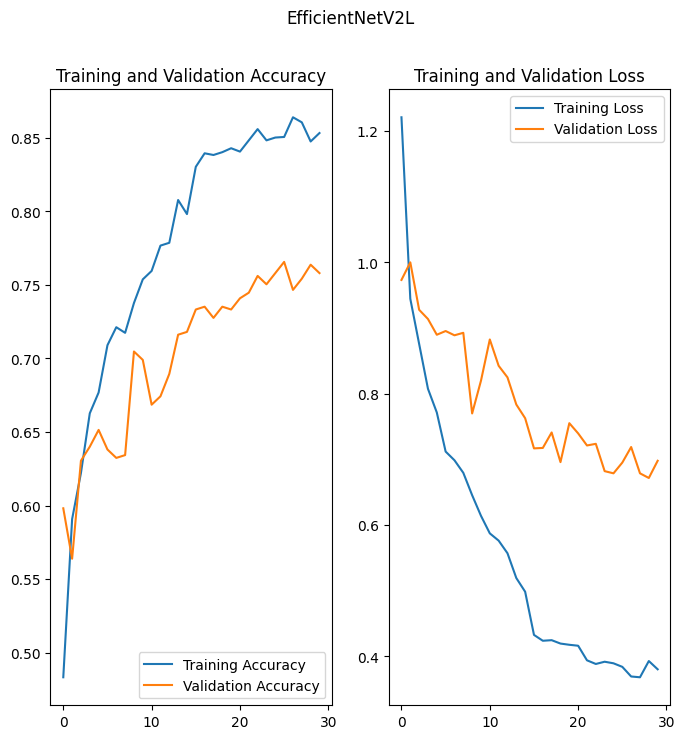

In [ ]:
# Plot history
plot_history(eff_history, 'EfficientNetV2L')

In [10]:
# Load best model
eff_model = keras.models.load_model(os.path.join(model_dir, 'eff_model2.h5'))

In [11]:
# Train and test accuracies
eff_train_acc = eff_model.evaluate(train_ds)
eff_test_acc = eff_model.evaluate(test_ds)
print('Train Accuracy: {:.2f}'.format(eff_train_acc[1]))
print('Test Accuracy: {:.2f}'.format(eff_test_acc[1]))

4/4 [==============================] - 16s 1s/step - loss: 0.7036 - accuracy: 0.7812
Train Accuracy: 0.89
Test Accuracy: 0.78


In [12]:
# Generate predictions and labels
test_labels =  []
test_preds = []
for image, label in test_ds.unbatch():
  prediction = np.argmax(eff_model.predict(np.expand_dims(image, 0), verbose=0))
  test_preds.append(prediction)
  test_labels.append(np.argmax(label))

In [13]:
# Classification Report for EfficientNetV2L
print(classification_report(test_labels, test_preds, target_names=class_labels))

              precision    recall  f1-score   support

        acne       1.00      0.94      0.97        16
      eczema       0.70      0.70      0.70        33
      fungal       0.75      0.83      0.79        29
   psoriasis       0.72      0.62      0.67        29
       warts       0.83      0.90      0.86        21

    accuracy                           0.77       128
   macro avg       0.80      0.80      0.80       128
weighted avg       0.77      0.77      0.77       128



In [14]:
# Defining function to plot confusion matrix
def plot_heatmap(y_true, y_pred, class_names, title):
    plt.figure(figsize=(10,10))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=True)

    plt.title(title, fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

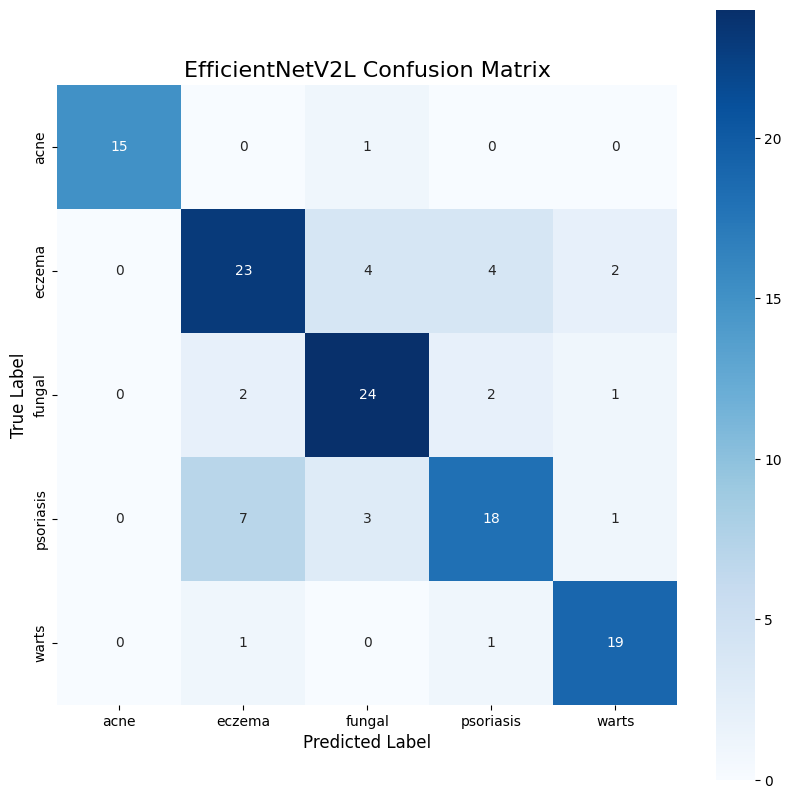

In [15]:
# Confusion Matrix for EfficientNetV2L
plot_heatmap(test_labels, test_preds, class_labels, title="EfficientNetV2L Confusion Matrix")

<a id='finetuning'></a>
## 5. Fine Tuning

In [ ]:
# Check base model layer names and trainable status
for layer in eff_model.layers:
  print(layer.name, layer.trainable)

input_3 True
sequential_1 True
rescaling_1 False
stem_conv False
stem_bn False
stem_activation False
block1a_project_conv False
block1a_project_bn False
block1a_project_activation False
block1a_add False
block1b_project_conv False
block1b_project_bn False
block1b_project_activation False
block1b_drop False
block1b_add False
block1c_project_conv False
block1c_project_bn False
block1c_project_activation False
block1c_drop False
block1c_add False
block1d_project_conv False
block1d_project_bn False
block1d_project_activation False
block1d_drop False
block1d_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_project_conv False
block2b_project_bn False
block2b_drop False
block2b_add False
block2c_expand_conv False
block2c_expand_bn False
block2c_expand_activation False
block2c_project_conv False
block2c_project_

In [ ]:
# Set layers after block 6 to be trainable
start_layer_name = 'block6a_expand_conv'
unfreeze = False

for layer in eff_model.layers:
  if start_layer_name in layer.name:
    unfreeze=True
  if unfreeze:
    if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

In [ ]:
# Recheck that only layers after block 6 are trainable
for layer in eff_model.layers:
  print(layer.name, layer.trainable)

input_3 True
sequential_1 True
rescaling_1 False
stem_conv False
stem_bn False
stem_activation False
block1a_project_conv False
block1a_project_bn False
block1a_project_activation False
block1a_add False
block1b_project_conv False
block1b_project_bn False
block1b_project_activation False
block1b_drop False
block1b_add False
block1c_project_conv False
block1c_project_bn False
block1c_project_activation False
block1c_drop False
block1c_add False
block1d_project_conv False
block1d_project_bn False
block1d_project_activation False
block1d_drop False
block1d_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_project_conv False
block2b_project_bn False
block2b_drop False
block2b_add False
block2c_expand_conv False
block2c_expand_bn False
block2c_expand_activation False
block2c_project_conv False
block2c_project_

In [ ]:
# Compile at a lower learning rate
eff_model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9, nesterov=True),
                   loss='categorical_crossentropy',
                   metrics=['accuracy']
                  )

In [ ]:
# Specify callbacks
callback_list = get_callbacks('eff_fine2.h5',
                              patience=6,
                              lr_factor=0.1)

# Fine tune model
eff_fine_history = eff_model.fit(train_ds,
                                 epochs=10,
                                 validation_data=val_ds,
                                 verbose=1,
                                 callbacks=callback_list)

Epoch 1/10
83/83 [==============================] - 134s 1s/step - loss: 0.3951 - accuracy: 0.8533 - val_loss: 0.5753 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 2/10
83/83 [==============================] - 93s 1s/step - loss: 0.3587 - accuracy: 0.8658 - val_loss: 0.6129 - val_accuracy: 0.7826 - lr: 1.0000e-04
Epoch 3/10
83/83 [==============================] - 90s 1s/step - loss: 0.3467 - accuracy: 0.8719 - val_loss: 0.6056 - val_accuracy: 0.7864 - lr: 1.0000e-04
Epoch 4/10
83/83 [==============================] - 93s 1s/step - loss: 0.3201 - accuracy: 0.8799 - val_loss: 0.5686 - val_accuracy: 0.8015 - lr: 1.0000e-04
Epoch 5/10
83/83 [==============================] - 68s 810ms/step - loss: 0.3054 - accuracy: 0.8879 - val_loss: 0.5952 - val_accuracy: 0.7902 - lr: 1.0000e-04
Epoch 6/10
83/83 [==============================] - 92s 1s/step - loss: 0.2712 - accuracy: 0.9031 - val_loss: 0.5183 - val_accuracy: 0.8242 - lr: 1.0000e-04
Epoch 7/10
83/83 [==============================] - 68

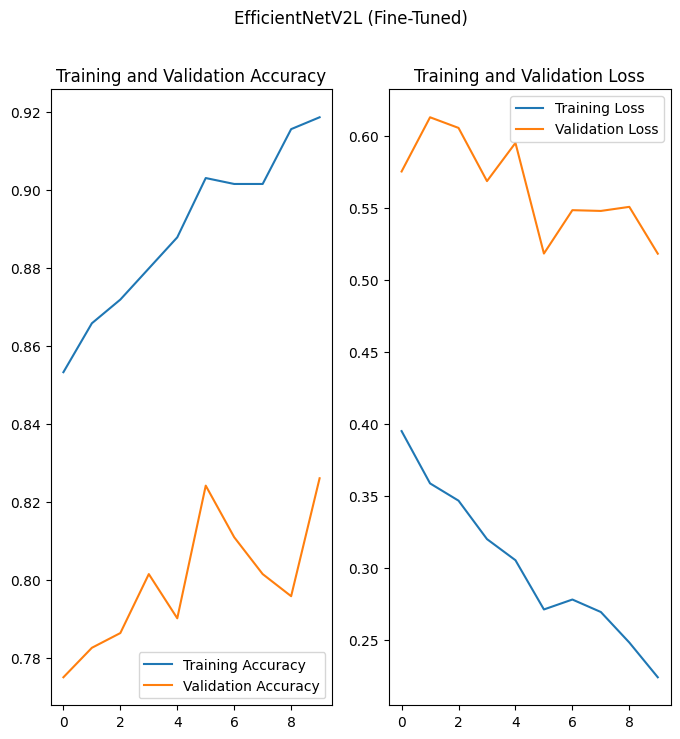

In [ ]:
# Plot history
plot_history(eff_fine_history, 'EfficientNetV2L (Fine-Tuned)')

In [16]:
# Load best model
eff_model = keras.models.load_model(os.path.join(model_dir, 'eff_fine2.h5'))

In [ ]:
# Train and test accuracies
eff_fine_train_acc = eff_model.evaluate(train_ds)
eff_fine_test_acc = eff_model.evaluate(test_ds)
print('Train Accuracy: {:.2f}'.format(eff_fine_train_acc[1]))
print('Test Accuracy: {:.2f}'.format(eff_fine_test_acc[1]))

4/4 [==============================] - 2s 399ms/step - loss: 0.3212 - accuracy: 0.8828
Train Accuracy: 0.93
Test Accuracy: 0.88


In [11]:
# Generate predictions and labels
test_labels =  []
test_preds = []
for image, label in test_ds.unbatch():
  prediction = np.argmax(eff_model.predict(np.expand_dims(image, 0), verbose=0))
  test_preds.append(prediction)
  test_labels.append(np.argmax(label))

In [12]:
# Classification Report for EfficientNetV2L (Fine-tuned)
print(classification_report(test_labels, test_preds, target_names=class_labels))

              precision    recall  f1-score   support

        acne       1.00      0.81      0.90        16
      eczema       0.79      0.79      0.79        33
      fungal       0.73      0.83      0.77        29
   psoriasis       0.83      0.83      0.83        29
       warts       0.90      0.86      0.88        21

    accuracy                           0.82       128
   macro avg       0.85      0.82      0.83       128
weighted avg       0.83      0.82      0.82       128



In [ ]:
# Classification Report for EfficientNetV2L (Fine-tuned)
print(classification_report(test_labels, test_preds, target_names=class_labels))

              precision    recall  f1-score   support

        acne       1.00      1.00      1.00         7
      eczema       0.82      0.80      0.81        40
      fungal       0.86      0.82      0.84        38
   psoriasis       0.66      0.79      0.72        24
       warts       0.94      0.84      0.89        19

    accuracy                           0.82       128
   macro avg       0.86      0.85      0.85       128
weighted avg       0.83      0.82      0.82       128



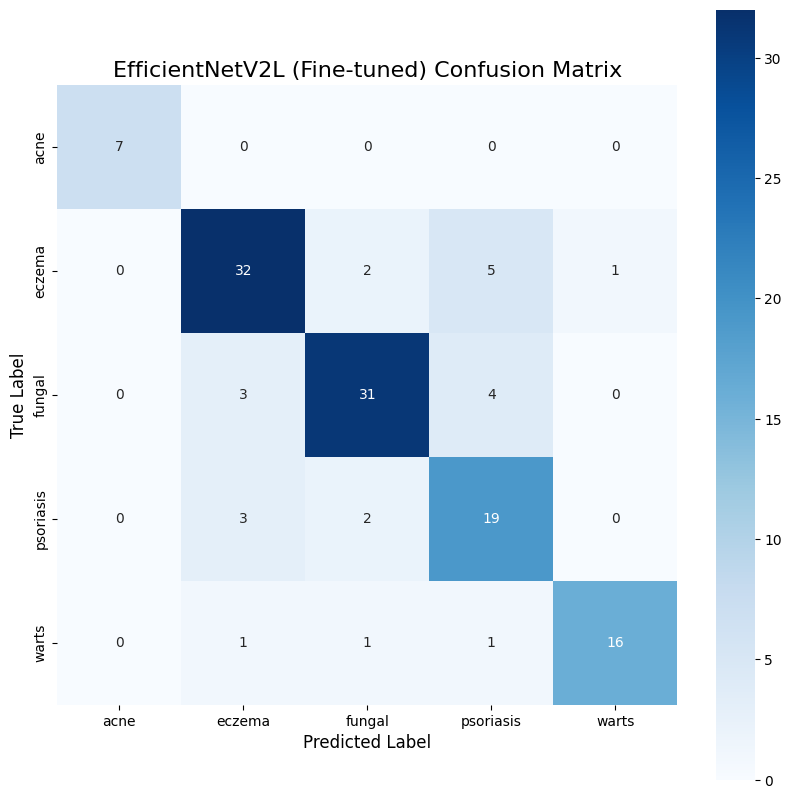

In [ ]:
# Confusion Matrix for EfficientNetV2L (Fine-tuned)
plot_heatmap(test_labels, test_preds, class_labels, title="EfficientNetV2L (Fine-tuned) Confusion Matrix")

### Models Summary

|Model|Train Accuracy|Test Accuracy|
|:---|:---:|:---|
|<b>EfficientNetB1 (Baseline Model)</b>|0.89|0.78|
|<b>EfficientNetB1 Fine-Tuned</b>|0.93|0.88|